# Importing the required modules

In [9]:
# Modules used for data handling and manipulation
import numpy as np
import pandas as pd
import json

# Modules used for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import pprint

# Modules used for preprocessing
from sklearn.preprocessing import StandardScaler

# Modules for lstm
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Bidirectional, BatchNormalization
from keras.callbacks import EarlyStopping

# Module for facebook prophet
import prophet

# Modules used for time series forecasting
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Modules used for model evaluation
from sklearn.metrics import mean_absolute_percentage_error
import model

# Modules used for preprocessing
from datetime import datetime, timedelta
import preprocess
from model import Model

# Modules used for object oriented programming
from abc import ABC, abstractmethod

# Module for suppressing warnings
import warnings 
warnings.filterwarnings('ignore')

# For suppressing status messages from Facebook Prophet
import logging
logging.getLogger("prophet").setLevel(logging.WARNING)
logging.getLogger("cmdstanpy").disabled=True

# Consolidating the data

In [2]:
electricity = preprocess.preprocess_modelling(as_numpy=False, clustered=True, stationary=False)
temperature = preprocess.preprocess("temperature")
precipitation = preprocess.preprocess("precipitation")

In [3]:
electricity = electricity[366:]

In [4]:
electricity = electricity.drop(pd.to_datetime("2015-01-01"))

In [5]:
weather = pd.merge(temperature, precipitation, on='date', how='inner').set_index("date")

# SARIMAX

In [6]:
# class for SARIMAX model
class SARIMAX_model(Model):
    
    def __init__(self, data, exogs, cluster: str, start_index = 0, window_stride = 28):
        """
         The constructor for the abstract class Model for standardize evaluation

         Args:
            data: the actual time series that needs to be predicted.
            exogs: the exogeneous variables particularly for SARIMAX.
            cluster: the cluster data which needs to be used (cluster_1 or cluster_0).
            window_stride: the stride (in days) for moving the train-test window; defaults to 28 days.

         Returns:
            - An object of abstract class SARIMA.
        """
        super().__init__(data, cluster, start_index, window_stride)
        self.exogs = exogs
    
    # trains the model
    def train_model(self, train, train_idx):
        model = SARIMAX(endog = train[self.cluster], 
                        exog = self.exogs[train_idx[0]: train_idx[1]], 
                        order = (1, 1, 0), 
                        seasonal_order = (1, 1, 0, 12))
        return model.fit()
    
    # obtains the forecasts for next five time steps
    def get_forecasts(self, test, test_idx):
        return self.trained_model.predict(start = self.data.index[test_idx[0]], 
                                        end = self.data.index[test_idx[0]] + timedelta(len(test) - 1),
                                        exog = self.exogs[test_idx[0]: test_idx[1]])

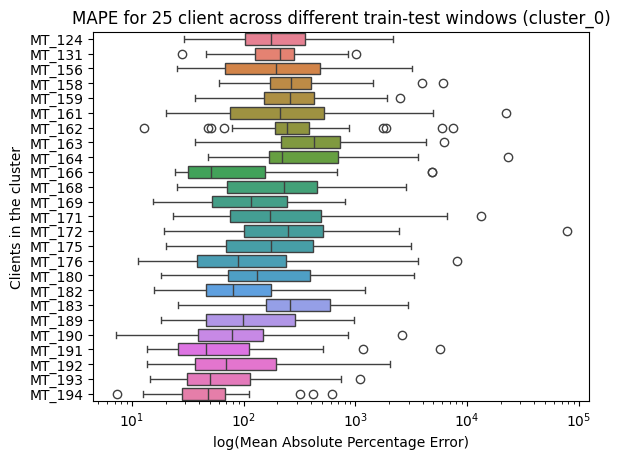

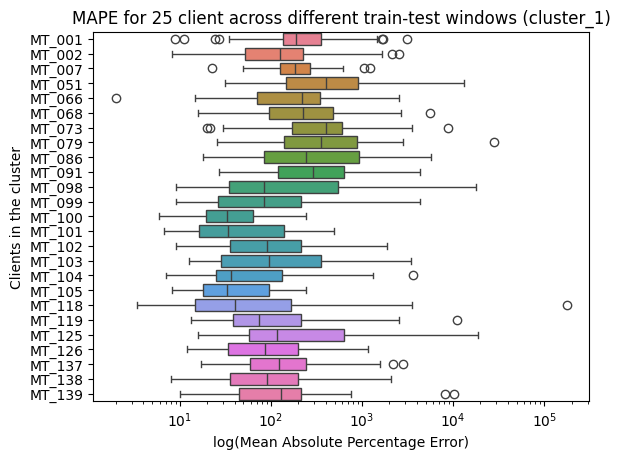

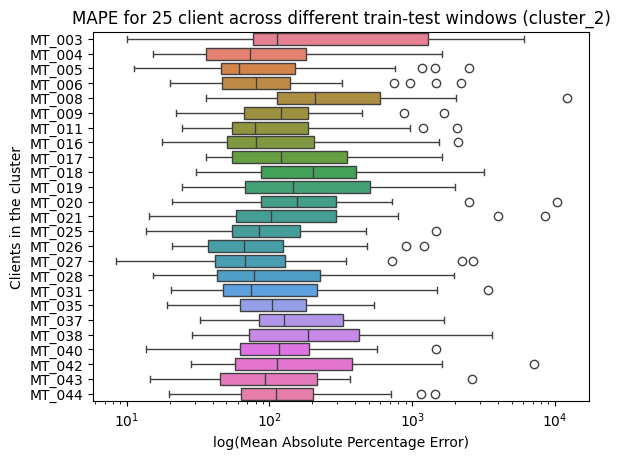

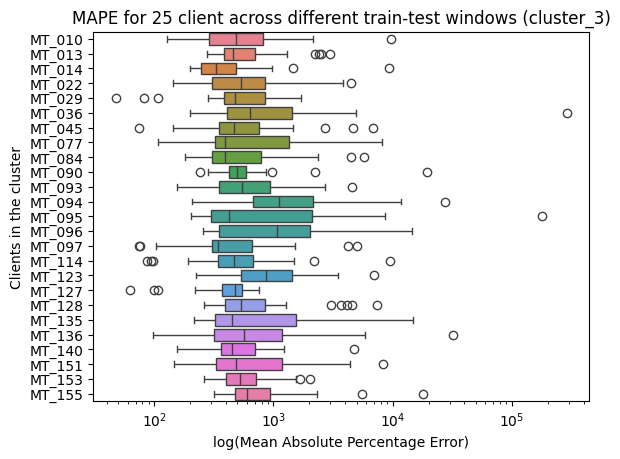

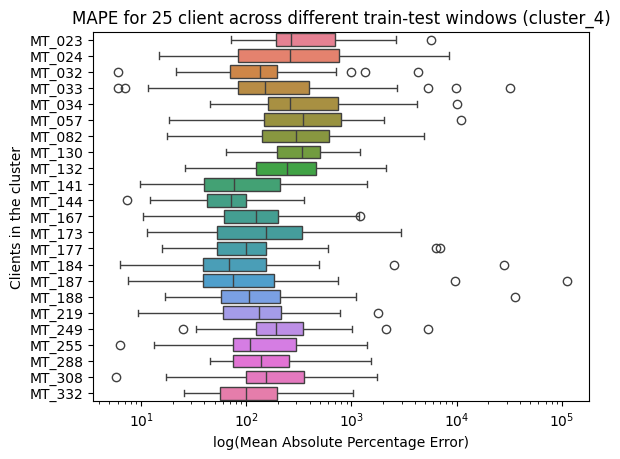

In [7]:
c = ["cluster_0", "cluster_1", "cluster_2", "cluster_3", "cluster_4"]
models = []
for i in c:
    m = SARIMAX_model(electricity, weather[366:], i, start_index = 366)
    m.cross_validate()
    m.mape_boxplot_by_client(25)
    models.append(m)

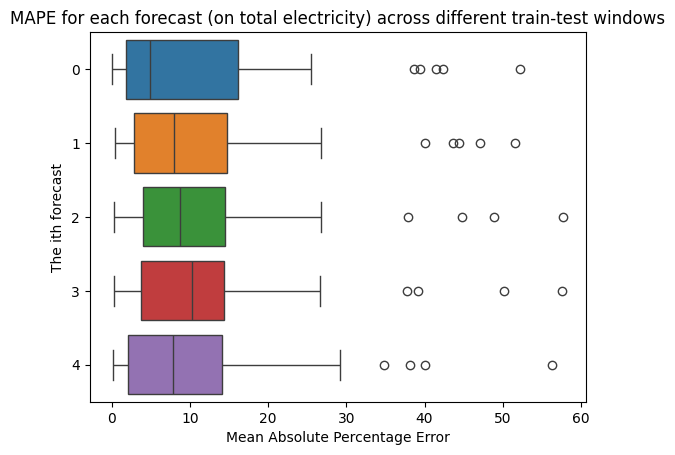

In [8]:
m.mape_boxplot_by_step(models)

# Facebook Prophet

In [10]:
class FacebookProphet_model(Model):
    
    def __init__(self, exogs, data, cluster, start_index = 0, window_stride = 28, holidays=True):
        super().__init__(data, cluster, start_index, window_stride)
        self.exogs = exogs
        self.holidays = holidays

    def restructure(self, df):
        df = df.reset_index()
        df["date"] = pd.to_datetime(df["date"])
        df = df.merge(self.exogs.reset_index())
        df = df.rename({"date": "ds", self.cluster:"y"}, axis=1)
        return df

    def train_model(self, train, train_idx):
        model = prophet.Prophet()
        for col in self.exogs.columns:
                model.add_regressor(col)

        if self.holidays:
            # Add Portugal holidays - helps catch outliers around New Year
            model.add_country_holidays(country_name='Portugal')

        #print(train.columns, self.exogs.columns)
        train = self.restructure(train)
        return model.fit(train.reset_index())
    
    def get_forecasts(self, test, test_idx):

        df = self.trained_model.make_future_dataframe(periods = self.ts_test)

        df = self.restructure(df.rename({"ds": "date"}, axis = 1)).drop(["index"], axis = 1)

        return self.trained_model.predict(df)["yhat"][self.ts_train:self.ts_train + self.ts_test]

    # Plot the results of each forecast
    def train_plot(self, n_forecast):
        diff = n_forecast*self.ts_window_stride
        train_idx = [min(diff, self.MAX_IDX), min(self.ts_train + diff, self.MAX_IDX)]
        test_idx = [min(self.ts_train + diff, self.MAX_IDX), min(self.ts_train + self.ts_test + diff, self.MAX_IDX)]
        
        train = self.data[train_idx[0]: train_idx[1]][[self.cluster]]
        test = self.data[test_idx[0]: test_idx[1]][[self.cluster]]

        # standardizing the train and test data
        train_std, test_std = self.standardize(train, test)

        # training the model
        self.trained_model = self.train_model(train_std, train_idx)

        plt.scatter(train.reset_index()['date'], train[self.cluster]/4, c='b')
        plt.scatter(test.reset_index()['date'], test[self.cluster]/4, c='r')
        
        df = self.trained_model.make_future_dataframe(periods = self.ts_test)

        df = self.restructure(df.rename({"ds": "date"}, axis = 1)).drop(["index"], axis = 1)

        forecast = self.trained_model.predict(df)[['ds', 'yhat']]

        # Destandardize for visualization
        forecast_std = self.destandardize(forecast[['yhat']])

        plt.plot(forecast['ds'], forecast_std/4, '-k')
        plt.xlabel('Date')
        plt.xticks(rotation=45, ha='right')
        plt.ylabel('Total electricity consumption, kWh')
        plt.legend(['Train actual', 'Test actual', 'Prediction'])

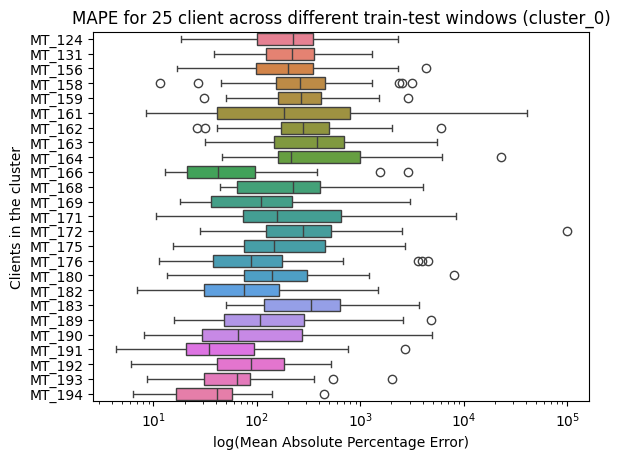

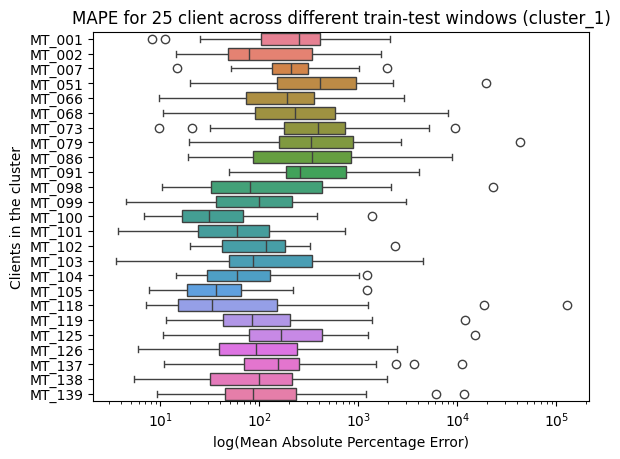

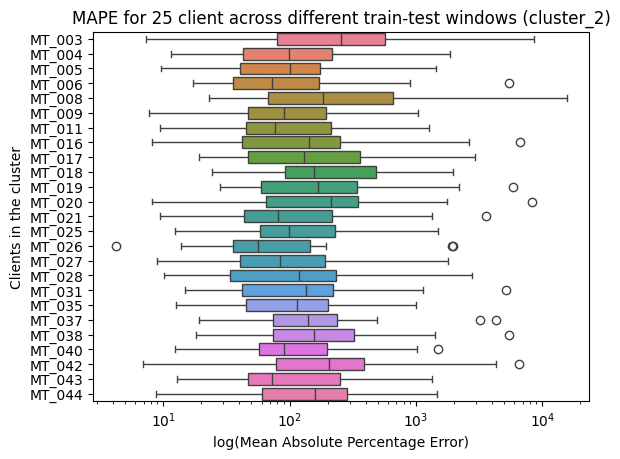

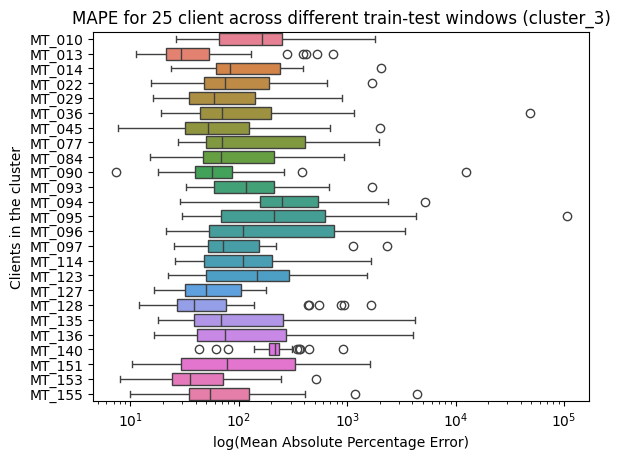

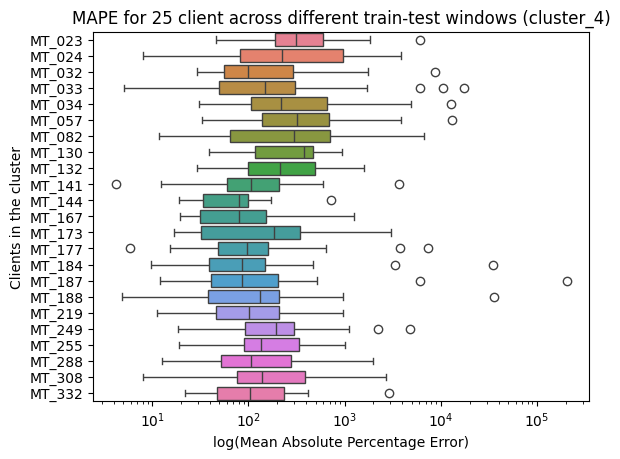

In [11]:
c = ["cluster_0", "cluster_1", "cluster_2", "cluster_3", "cluster_4"] 
models = []
for i in c:
    m = FacebookProphet_model(weather[366:], electricity, i, start_index = 366)
    m.cross_validate()
    m.mape_boxplot_by_client(25)
    models.append(m)

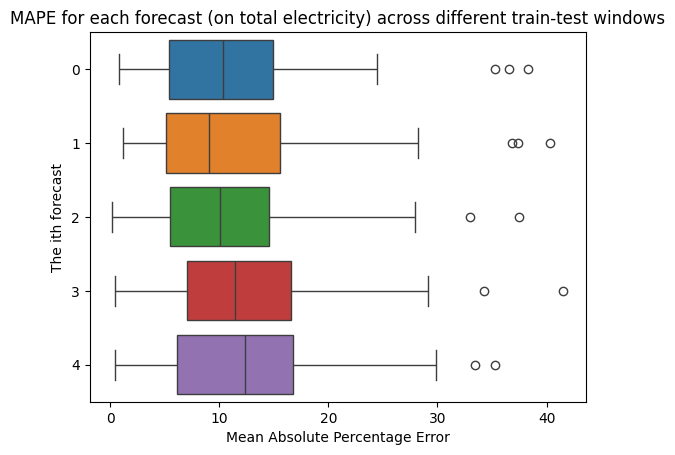

In [12]:
m.mape_boxplot_by_step(models)

# LSTM

In [37]:
class LSTM_model(Model):
    
    def __init__(self, exogs, data, cluster, params: dict, start_index = 0, window_stride = 28):
        self.exogs = exogs
        data["date"] = pd.to_datetime(data["date"])
        data = data.merge(weather.reset_index())
        self.params = params
        super().__init__(data, cluster, start_index, window_stride)
        self.ts_train = 365

    def restructure(self, X):
        
        x = np.reshape(X[["tmin", "tmax", "precip"]].values, (len(X), 1, 3))
        y = X[self.cluster].values
        
        return x, y

    def train_model(self, x_train, y_train):        
        regressor = Sequential()
        regressor.add(Bidirectional(LSTM(units=self.params["num_units"], 
                                         activation=self.params["activation_function"], 
                                         return_sequences=True), 
                                         input_shape=(1,3)))
        regressor.add(Dropout(0.2))
        regressor.add(LSTM(units=30, activation=self.params["activation_function"], return_sequences=True))
        regressor.add(Dropout(0.2))
        regressor.add(LSTM(units=15, activation=self.params["activation_function"]))
        regressor.add(Dropout(0.3))
        regressor.add(BatchNormalization())
        regressor.add(Dense(units=64, activation='relu'))
        regressor.add(Dropout(0.2))
        regressor.add(Dense(units=1))

        regressor.compile(optimizer = self.params["optimizer"], loss = self.params["loss_function"])

        early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)
        regressor.fit(x_train[:self.ts_train - 10], y_train[:self.ts_train - 10], batch_size = self.params["batch_size"], 
                      epochs = self.params["num_epochs"], verbose = 0,
                      validation_data = (x_train[self.ts_train - 10:], y_train[self.ts_train - 10:]),
                      callbacks = [early_stopping])

        return regressor
    
    def get_forecasts(self, x_test):

        return self.trained_model.predict(x_test).flatten()
    
    def cross_validate(self):
      
      train_idx = [0, self.ts_train]
      test_idx = [self.ts_train, self.ts_train + self.ts_test]

      for split_id in range(50):

         if test_idx[0] == test_idx[1]:
            break 
         
         cols = [self.cluster, "tmin", "tmax", "precip"]
         train = self.data[train_idx[0]: train_idx[1]][cols]
         test = self.data[test_idx[0]: test_idx[1]][cols]

         self.scaler, train, test = self.standardize(train, test)

         x_train, y_train = self.restructure(train)
         x_test, y_test = self.restructure(test)

         self.trained_model = self.train_model(x_train, y_train)

         preds = self.get_forecasts(x_test)
         
         self.forecasts[split_id] = {"pred": list(preds),
                                     "train_date_range": train_idx,
                                     "test_date_range": test_idx}
   
         test_np = y_test.flatten()
         mape_by_forecast = np.abs((test_np - self.forecasts[split_id]["pred"])/(test_np))*100
         self.forecasts[split_id]["mape_by_forecast"] = mape_by_forecast

         train_idx = [train_idx[0] + self.ts_window_stride, 
                     min(train_idx[1] + self.ts_window_stride, 
                        self.MAX_IDX)]
         test_idx = [test_idx[0] + self.ts_window_stride, 
                     min(test_idx[1] + self.ts_window_stride, 
                        self.MAX_IDX)]
        
         if test_idx[0] > len(self.data):
            break

Epoch 109: early stopping
Restoring model weights from the end of the best epoch: 89.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Epoch 139: early stopping
Restoring model weights from the end of the best epoch: 119.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Epoch 91: early stopping
Restoring model weights from the end of the best epoch: 71.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Epoch 93: early stopping
Restoring model weights from the end of the best epoch: 73.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
Epoch 21: early stopping
Restoring model weights from the end of the best epoch: 1.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Epoch 88: early stopping
Restoring model weights from the end of the best epoch: 68.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Epoch 64: early stopping
Restoring model weights from the end of the best epoch: 44.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Epoch 118: early stopping
Restoring model weights from the end of the best epoch: 98.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Epoch

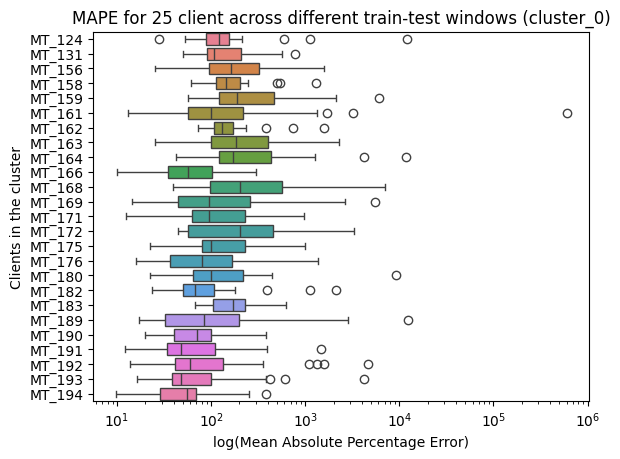

Epoch 94: early stopping
Restoring model weights from the end of the best epoch: 74.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Epoch 29: early stopping
Restoring model weights from the end of the best epoch: 9.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Epoch 115: early stopping
Restoring model weights from the end of the best epoch: 95.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Epoch 124: early stopping
Restoring model weights from the end of the best epoch: 104.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
Epoch 83: early stopping
Restoring model weights from the end of the best epoch: 63.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Epoch 62: early stopping
Restoring model weights from the end of the best epoch: 42.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Epoch 23: early stopping
Restoring model weights from the end of the best epoch: 3.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Epoch 130: early stopping
Restoring model weights from the end of the best epoch: 110.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Epoch

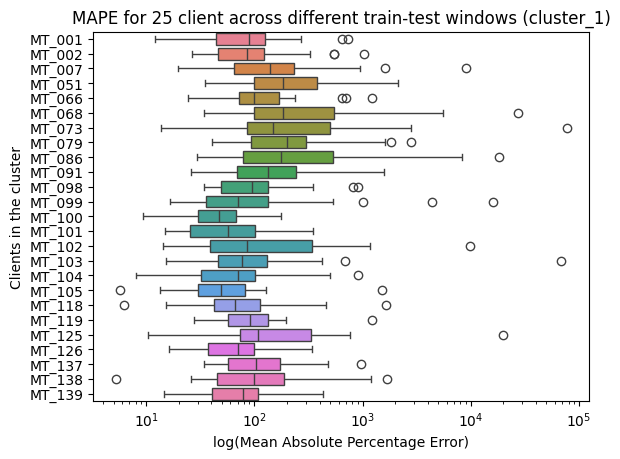

Epoch 128: early stopping
Restoring model weights from the end of the best epoch: 108.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Epoch 122: early stopping
Restoring model weights from the end of the best epoch: 102.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
Epoch 78: early stopping
Restoring model weights from the end of the best epoch: 58.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Epoch 59: early stopping
Restoring model weights from the end of the best epoch: 39.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Epoch 120: early stopping
Restoring model weights from the end of the best epoch: 100.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Epoch 134: early stopping
Restoring model weights from the end of the best epoch: 114.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
Epoch 74: early stopping
Restoring model weights from the end of the best epoch: 54.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
Epoch 38: early stopping
Restoring model weights from the end of the best epoch: 18.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


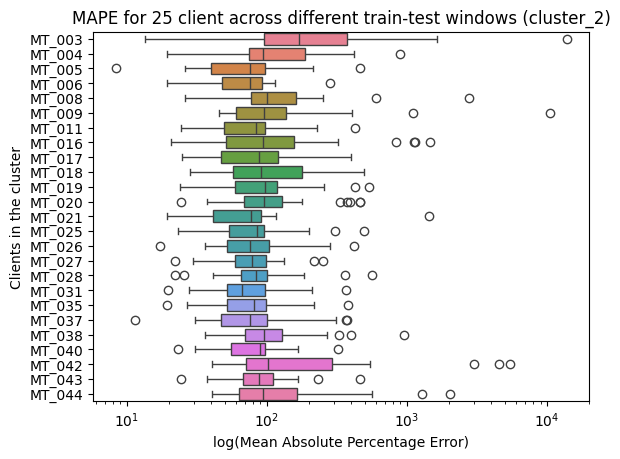

Epoch 43: early stopping
Restoring model weights from the end of the best epoch: 23.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
Epoch 69: early stopping
Restoring model weights from the end of the best epoch: 49.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Epoch 43: early stopping
Restoring model weights from the end of the best epoch: 23.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Epoch 38: early stopping
Restoring model weights from the end of the best epoch: 18.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Epoch 70: early stopping
Restoring model weights from the end of the best epoch: 50.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
Epoch 45: early stopping
Restoring model weights from the end of the best epoch: 25.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
Epoch 51: early stopping
Restoring model weights from the end of the best epoch: 31.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
Epoch 33: early stopping
Restoring model weights from the end of the best epoch: 13.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
Epoch 26

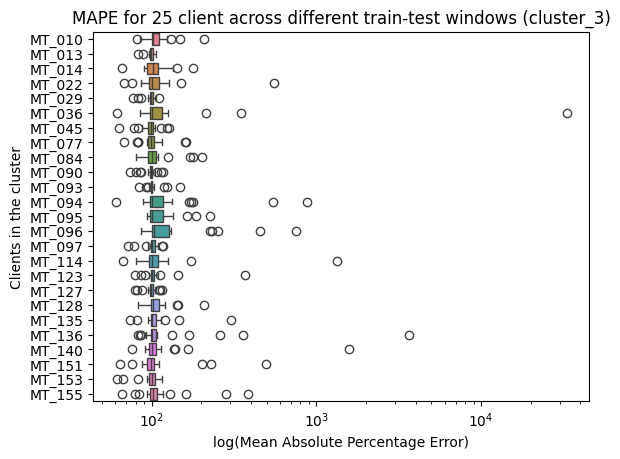

Epoch 21: early stopping
Restoring model weights from the end of the best epoch: 1.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
Epoch 127: early stopping
Restoring model weights from the end of the best epoch: 107.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Epoch 92: early stopping
Restoring model weights from the end of the best epoch: 72.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
Epoch 94: early stopping
Restoring model weights from the end of the best epoch: 74.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
Epoch 21: early stopping
Restoring model weights from the end of the best epoch: 1.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
Epoch 34: early stopping
Restoring model weights from the end of the best epoch: 14.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
Epoch 21: early stopping
Restoring model weights from the end of the best epoch: 1.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
Epoch 23: early stopping
Restoring model weights from the end of the best epoch: 3.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
Epoch 55: 

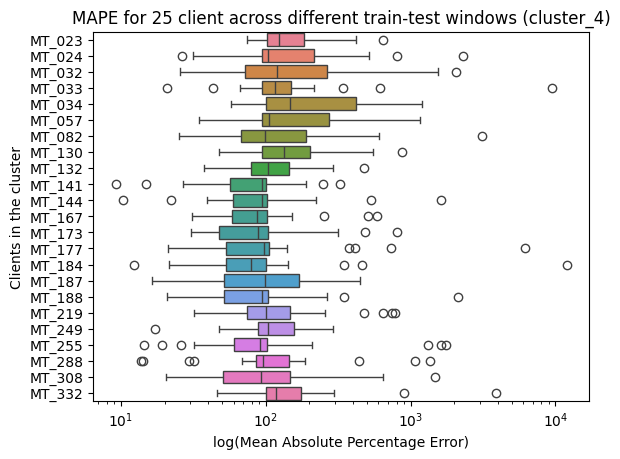

In [38]:
params = {
    "num_units": 60,
    "activation_function": 'relu',
    "optimizer": "adam",
    "loss_function": "mse",
    "batch_size": 32,
    "num_epochs": 300
}

c = ["cluster_0", "cluster_1", "cluster_2", "cluster_3", "cluster_4"] 
models = []
for i in c:
    m = LSTM_model(weather[366:].reset_index(), electricity.reset_index(), 
                   i, params, start_index = 366)
    m.cross_validate()
    m.mape_boxplot_by_client(25)
    models.append(m)

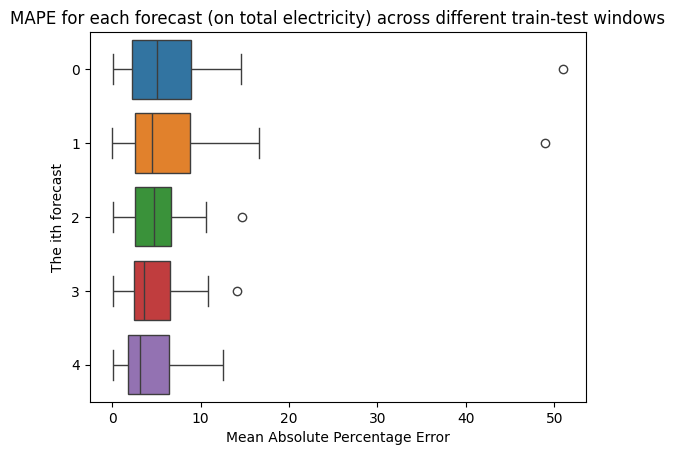

In [ ]:
m.mape_boxplot_by_step(models)